In [1]:
#hide
from fastai.vision.all import *
from utils import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data('https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz')


## Handwritten number recognition without Machine Learning

TLDR: creating image recognition using only simple math and understanding how different error formulas affect results.

While looking at the latest update to FastAi, Jeremy Howard encourages people that before starting to work on a machine learning solution, to try and build a non ML baseline solution first, so that you can evaluate your final model performance against.
He demonstrated using the MNIST dataset which is thousands of hand written digits scanned and labled, and was one of the early datasets used for computer vision.  His version just used the scanned 3s and 7s as an example and get a 90% accuracy rate at telling them apart. This is interesting, however, it's clear that if the only posibilities are 3 or 7, that limits the scope for error of mislableing.
I wanted to try and expand this across all of the digits, to find out what sort of accuracy rate was possible and also what digits were the hardest to tell apart, and where the largest area of mislabling was and then to see if this applied also to the machine learning model.

In [3]:
#hide
Path.BASE_PATH = path

I'm not going to go into too much of the detail here as it's covered in the course content, but basically for each of the images we're needing to:
* get a list of all the image files on disk - these are all greyscale png files of 28x28 pixels
* load each image file into a 2d PyTorch Tensor (a specialised array optimized for GPU batch calculations)
* combine all the tensors into a single stacked tensor, where the first demension indicates the image number
* for each pixel in the original image size, create the mean of all of the values of all of the images - that is create the avg for all of the other values of that character

repeat this for both the training set and testing set images. I'm returning lists containing outputs for each of tese steps as I can never decide to throw anything away as we might (just) need it right??


In [40]:
def load_chars(digit,set_name):
    files = (path/set_name/str(digit)).ls().sorted()
    img_tensors = [tensor(Image.open(f)).float() for f in files]
    stacked_tensors = torch.stack(img_tensors)
    img_mean = stacked_tensors.mean(0)
    return [digit,img_mean,stacked_tensors,img_tensors,files]

In [41]:
def load_sets(digit):
    training = load_chars(digit,'training')
    testing = load_chars(digit,'testing')
    return [training,testing]

In [43]:
%time all_digits = [load_sets(i) for i in range(10)]

CPU times: user 46.8 s, sys: 7.56 s, total: 54.4 s
Wall time: 1min 15s


In [133]:
all_means = [ i[0][1] for i in all_digits]
training_img_counts = [ len(i[0][2]) for i in all_digits]

## Looking at our data

It's helpful to start by visualising our data and making an initial judgement as to strengths and limitations of our data set.
Below are the calculated mean images for the training and test set respectively.

Straight away we can say:
* the testing set looks to be representative of the training set
* the digits look to be very uniform - there doesn't seem to be examples of 7s with a crossbar, 4s with a closed top, or 1s with a horizontal serif at the top or bottom

with this in mind, we shouldn't expect this to generalize very well if our production model will contain these sorts of differences.  This is called out of domain data.

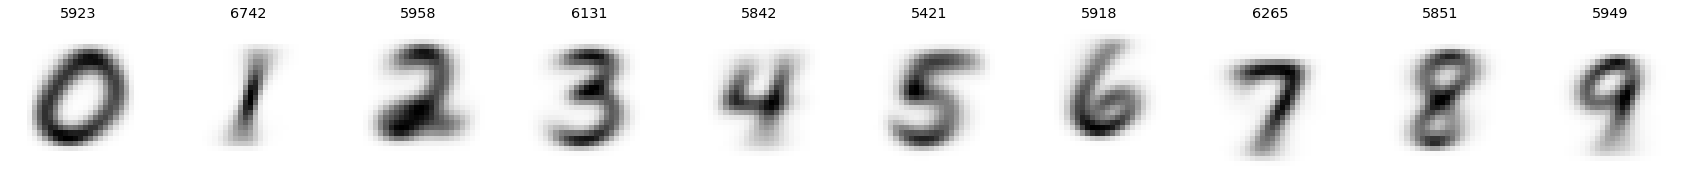

In [45]:
show_images(all_means,titles=training_img_counts)

The figures above show the mean of all the images, and the number above is the number of images included within the set for the training set. Lets do the same with the testing (validation) set that the data has already been presplit into.

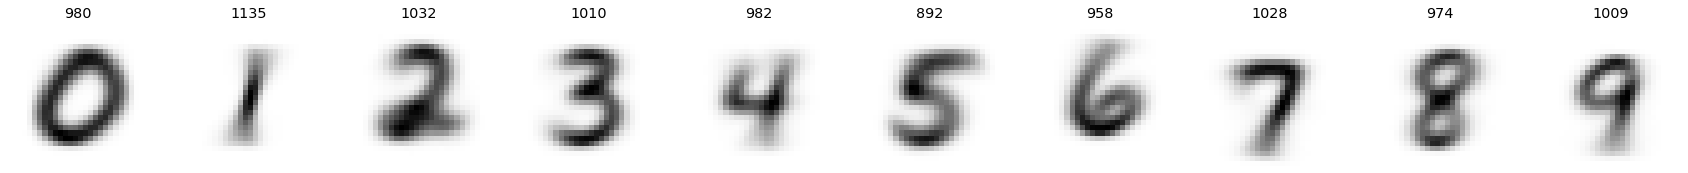

In [46]:
all_testing_means = [ i[1][1] for i in all_digits]
testing_img_counts = [ len(i[1][2]) for i in all_digits]
show_images(all_testing_means,titles=testing_img_counts)

## Measurement



When we're evaluating our images to try and decide which number it represents, we need a way to score how well it matches the 10 mean examples we generated above.  
There are two main conventions to do this:
* Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
* Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

For this project I started using the first, but then when i tried using the second i saw dramatically better results.  Let's see if we can identify what's going on.

In [47]:
#def mnist_distance_L1_norm(a,b): return (a-b).abs().mean((-1,-2))
def mnist_distance_L1_norm(a,b): return F.l1_loss(a,b)
#F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

In [48]:
#def mnist_distance_L2_norm(a,b): return ((a - b)**2).mean().sqrt()
def mnist_distance_L2_norm(a,b): return F.mse_loss(a,b).sqrt()


Lets choose a digit and then use the above to see which number it's closer to

<AxesSubplot:>

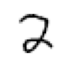

In [49]:
this_num =  all_digits[2][0][3][23]
show_image(this_num)

Let's use our distance function to check each of the means and then make a prediction based on the smallest error


In [50]:
def predict(x,l2_norm = False): 
    if l2_norm:
        tens = tensor([mnist_distance_L2_norm(x,n) for n in (all_means)])
    else:
        tens = tensor([mnist_distance_L1_norm(x,n) for n in (all_means)])
    min_ten = torch.min(tens,-1)
    idx = min_ten.indices.item()
    return [idx, tens]

This function will output it's prediction, and then a tensor of all of the error scores for each of the numbers. The digit with the lowest error score will be the prediction. If the number was exactly the same as one of the means, it would score a zero. 
Below we can see it running first using L1 Norm, and then L2 Norm. Notice how the L2 norm results have a much higher spread between different digits.


In [51]:
predict(this_num,False)

[2,
 tensor([44.9602, 34.6944, 33.9508, 38.8326, 39.2880, 40.3810, 39.6262, 38.7843, 39.4454, 41.3685])]

In [52]:
predict(this_num,True)

[2,
 tensor([76.8280, 75.5432, 58.6750, 70.2318, 72.4596, 71.0759, 71.9856, 74.0780, 70.3070, 76.6593])]

This gets the answer here correct both times, so how about we try this on the testing sets to see how acurate things are in bulk. To do this we'll need a new function

In [53]:
def is_num(x,y,l2_norm = False): 
    return int(predict(x,l2_norm)[0]==y)


In [54]:
print('is this a 4?: ',is_num(this_num,4),' is this a 2?: ',is_num(this_num,2))

is this a 4?:  0  is this a 2?:  1


## Calculating our system's accuracy

In [55]:
def Average(lst): 
    return sum(lst) / len(lst) 
def test_all(num,batch,l2_norm = False):
    res = [is_num(x,num,l2_norm) for x in batch]
    avg = Average(res )  
    return [num,avg,res,batch]
                                               

In [70]:
all_results =  [test_all( i[1][0],i[1][3],False) for i in all_digits]
overal_accuracy = Average([i[1] for i in all_results])
overal_accuracy

0.6610330933054313

This means that our similarity model gets the number right 66% of the time.  This is much lower than the 90% that Jeremy got for his 3s and 7s detector, but makes sense given the added complexity of the greater number of potential numbers.  
So let's dig in a bit and see where we're doing well and where we could do better.

<AxesSubplot:xlabel='number'>

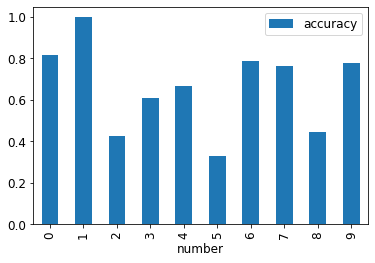

In [57]:
df = pd.DataFrame([[i[0],i[1]] for i in all_results],columns=['number','accuracy']).set_index('number')
df.plot(kind='bar')

## Problem 5s

5s are clearly a problem.  So lets take a look at some examples which are getting mis identified.



In [73]:
all_fives = all_results[5]
correct_fives = []
wrong_fives = []
for i in range(len(all_fives[2])):
    if all_fives[2][i] == 1:
        correct_fives.append(all_fives[3][i])
    else:
        wrong_fives.append(all_fives[3][i])

Our correct fives - we can just look at the first 5 and then dig into the actual predictions to see how close they were.

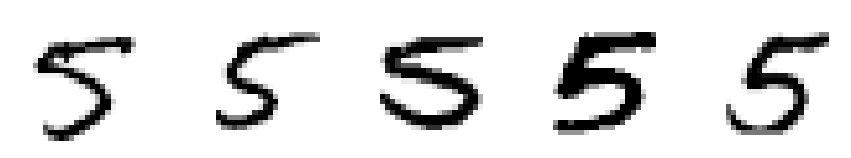

In [74]:
show_images(correct_fives[:5])

In [132]:
[predict(i,False) for i in correct_fives[:5]]

[[5,
  tensor([46.2950, 40.3995, 49.9191, 38.6378, 40.4930, 34.6519, 46.4331, 35.8630, 39.3433, 36.2096])],
 [5,
  tensor([39.7384, 32.3414, 41.7955, 36.8103, 35.7636, 30.0181, 38.5122, 36.8192, 34.1151, 32.8188])],
 [5,
  tensor([45.2640, 50.8017, 51.6929, 45.0456, 50.4784, 42.1319, 51.0475, 50.3729, 46.4908, 48.1094])],
 [5,
  tensor([46.4578, 55.9442, 57.8127, 45.6665, 49.5723, 44.4466, 52.2558, 56.0903, 48.2307, 48.5962])],
 [5,
  tensor([45.1574, 41.7769, 49.2573, 36.8999, 40.3318, 33.4657, 44.6567, 43.0143, 38.6685, 37.0766])]]

And let's do the same from our wrongly identified 5s and also take a look at what the system predicted them as - each one was predicted as being a different digit - what could be going on here?


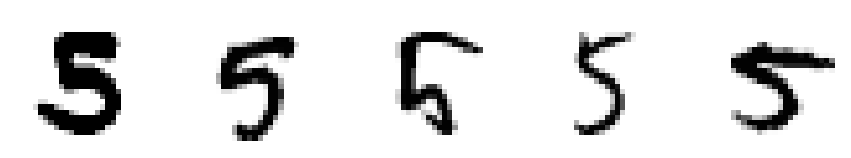

In [76]:
show_images(wrong_fives[:5])

In [130]:
[predict(i,False) for i in wrong_fives[:5]]

[[3,
  tensor([48.2975, 51.0353, 50.6927, 39.4165, 53.1028, 42.9255, 53.1489, 52.9216, 42.0849, 48.8840])],
 [9,
  tensor([44.4193, 41.7962, 50.0596, 37.8979, 36.3615, 34.4470, 44.0016, 36.7527, 38.4243, 31.5450])],
 [4,
  tensor([47.7381, 38.7883, 40.7202, 43.8045, 36.6001, 38.4213, 38.2954, 44.0573, 37.1769, 39.1352])],
 [1,
  tensor([41.8293, 28.5392, 40.8829, 30.7990, 34.0023, 28.9300, 36.3248, 32.1848, 31.2342, 30.0607])],
 [7,
  tensor([43.9292, 39.5532, 49.8579, 39.4794, 40.2011, 36.8015, 46.5581, 34.9576, 38.0033, 36.6342])]]

Lets look at one of our wrong 5s and lets visualize what's correct and whats wrong.

<AxesSubplot:>

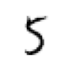

In [82]:
this_five = wrong_fives[3]
show_image(this_five)

## Identifying differences

This 5 was incorrectly identified as a 1.  Let's plot the differences between this character and the means for 5 and 1 to see if we can see what's causing this.

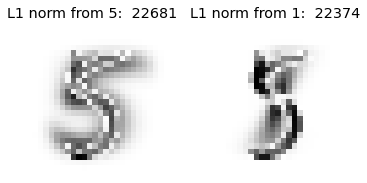

In [118]:
mean_five = all_digits[5][0][1]
mean_one = all_digits[1][0][1]
diff5 = abs(mean_five - this_five )
diff1 = abs(mean_one - this_five )
sum5 = int(diff5.sum().item())
sum1 = int(diff1.sum().item())

show_images([diff5,diff1],titles=[f'L1 norm from 5:  {sum5}',f'L1 norm from 1:  {sum1}'])

The darker areas show where the characers don't line up.
We can see that because this 5 is quite narrow, it leaves a lot of lightly shaded parts as a lot of the images of the mean 5 are wider.  
When compared to the 1, there are much darker overlaps where the 5 extends outside the mean area, but there are a smaller number of light grey areas. When we total the sum of the differences, the 1 has a lower error score and thus this particular 5 is predicted to be a 1.
We can see here that in this case, the areas where the 5 extends outside the 1 mean are much more meaningfull than where the 5 doesn't cover all of the grey area for the 5.
Let's see how using RMSE or L2 Norm changes this.

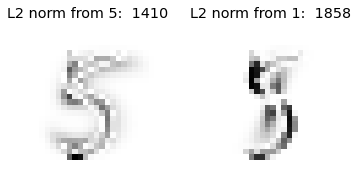

In [126]:
diff5 = (mean_five - this_five )**2
diff1 = (mean_one - this_five )**2
sum5 = int(math.sqrt(diff5.sum().item()))
sum1 = int(math.sqrt(diff1.sum().item()))

show_images([diff5,diff1],titles=[f'L2 norm from 5:  {sum5}',f'L2 norm from 1:  {sum1}'])

This makes a big difference, with the larger the changes from the mean being weighted much higher and thus, in this case the 5 character would be sellected vs the 1.
But how much of a change will this make to the system results in general.

In [127]:
all_results_l2 =  [test_all( i[1][0],i[1][3],True) for i in all_digits]
overal_accuracy_l2 = Average([i[1] for i in all_results_l2])
overal_accuracy_l2

0.8172567959938041

<AxesSubplot:xlabel='number'>

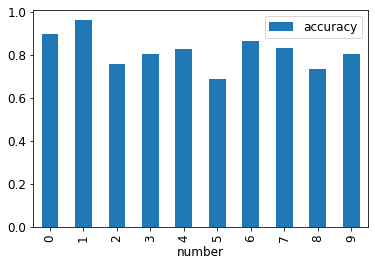

In [128]:
df = pd.DataFrame([[i[0],i[1]] for i in all_results_l2],columns=['number','accuracy']).set_index('number')
df.plot(kind='bar')

In this situation using RMSE has improved our system from 66% to 82%
